In [1]:
import os

# Fallback for new M-chips architecture
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

from huggingface_hub import hf_hub_download
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm 
import glob
import laion_clap
import lime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import json
import torch

/Users/jakubwlodarz/SIWY-Deepfake-explainability/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jakubwlodarz/SIWY-Deepfake-explainability/.venv/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
def get_clap_model():
    repo_id = "lukewys/laion_clap"
    filename = "music_audioset_epoch_15_esc_90.14.pt"
    
    print(f"Checking for model {filename}...")
    ckpt_path = hf_hub_download(repo_id=repo_id, filename=filename)
    print(f"Model path: {ckpt_path}")

    model = laion_clap.CLAP_Module(enable_fusion=False, amodel='HTSAT-base')
    model.load_ckpt(ckpt_path)
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
        print("Using CUDA...")
    elif torch.backends.mps.is_available():
        device = "mps"
        print("Using MPS...")
    else:
        print("Using CPU...")

    model.to(device)
    model.eval()
    print(f"Model loaded on device: {device}")
    return model

clap_model = get_clap_model()

Checking for model music_audioset_epoch_15_esc_90.14.pt...
Model path: /Users/jakubwlodarz/.cache/huggingface/hub/models--lukewys--laion_clap/snapshots/b3708341862f581175dba5c356a4ebf74a9b6651/music_audioset_epoch_15_esc_90.14.pt


/Users/jakubwlodarz/SIWY-Deepfake-explainability/.venv/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load the specified checkpoint /Users/jakubwlodarz/.cache/huggingface/hub/models--lukewys--laion_clap/snapshots/b3708341862f581175dba5c356a4ebf74a9b6651/music_audioset_epoch_15_esc_90.14.pt from users.
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.bloc

In [36]:
# Current configuration of folders and labels for experiment
from pathlib import Path


base_dir = "../data"
folders_map = {
    "lastfm/audio": 0,
    "suno/audio": 1,
    "udio/audio": 1,
}

# Check if base directory exists
if not os.path.exists(base_dir):
    raise FileNotFoundError(f"Base directory '{base_dir}' does not exist")

# Check if folders exist
for folder in folders_map.keys():
    folder_path = os.path.join(base_dir, folder)
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Folder '{folder}' does not exist in base directory")

data_list = []

print("Starting audio processing...")

for folder_name, label in folders_map.items():
    # Search for mp3 files
    search_path = os.path.join(base_dir, folder_name, "*")
    files = [f for f in glob.glob(search_path) if f.endswith('.mp3')]
    files = files

    if not files:
        print(f"Warning: No files found in folder: {folder_name}")
        continue

    print(f"Folder '{folder_name}': found {len(files)} files")

    # Process in batches to manage memory usage
    batch_size = 4 

    for i in tqdm(range(0, len(files), batch_size), desc=f"Processing {folder_name}"):
        batch_files = files[i:i + batch_size]
        folder_path = os.path.join(base_dir, folder_name, 'audio_embeddings')
        
        if not os.path.isdir(folder_path):
            os.mkdir(folder_path)

        try:
            # We can omit files that were already processed earlier
            removed_batch_files = []
            for idx, file_path in enumerate(batch_files):
                embedding_path = Path(folder_path) / Path(file_path.replace('mp3', 'json')).name
                if embedding_path.exists():
                    with open(embedding_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)

                    data_list.append(data)
                    removed_batch_files.append(file_path)

            batch_files = [f for f in batch_files if f not in removed_batch_files]
            if len(batch_files) == 0:
                continue

            # Generate embeddings
            with torch.no_grad():
                emb = clap_model.get_audio_embedding_from_filelist(x=batch_files, use_tensor=False)

            # Store results
            for idx, file_path in enumerate(batch_files):
                data = {
                    "filename": file_path,
                    "label": label,
                    "source": folder_name,
                    "embedding": emb[idx]
                }

                data_list.append(data)

                # Embedding must be transformed to a list for JSON file
                data['embedding'] = emb[idx].tolist()

                embedding_path = Path(folder_path) / Path(file_path.replace('mp3', 'json')).name
                with open(embedding_path, "w", encoding="utf-8") as f:
                    json.dump(data, f, indent=4)

        except Exception as e:
            print(f"Error processing batch starting with {batch_files[0]}: {e}")

# Convert to DataFrame
df = pd.DataFrame(data_list)
print(f"Finished! Processed {len(df)} tracks")

Starting audio processing...
Folder 'lastfm/audio': found 995 files


Processing lastfm/audio: 100%|██████████| 249/249 [00:00<00:00, 496.18it/s]


Folder 'suno/audio': found 999 files


Processing suno/audio: 100%|██████████| 250/250 [00:04<00:00, 61.02it/s]


Folder 'udio/audio': found 1000 files


Processing udio/audio: 100%|██████████| 250/250 [00:04<00:00, 52.98it/s]

Finished! Processed 2994 tracks


In [38]:
# Expand the list of embeddings into separate columns (embed_0, embed_1, ...)
X = np.stack(df["embedding"].values)
feature_names = [f"embed_{i}" for i in range(X.shape[1])]
X_df = pd.DataFrame(X, columns=feature_names)

y = df["label"].values

# Split into Train and Test sets (keeping indices to retrieve filenames later)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_df, y, df.index, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Train set shape: (2395, 512)
Test set shape: (599, 512)


In [43]:
# Create folder for output plots
folder_name = "plots/knn"

orig_cwd = os.getcwd()
os.makedirs(folder_name, exist_ok=True)
target_path = os.path.join(orig_cwd, folder_name)
print(f"Using folder for outputs: {target_path}")

Using folder for outputs: /Users/jakubwlodarz/SIWY-Deepfake-explainability/src/plots/knn


In [40]:
# Initialize and train
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Predictions
y_pred = knn_model.predict(X_test)

# Report
print("--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred, target_names=["Real (0)", "AI (1)"]))

# Confusion Matrix
print("--- CONFUSION MATRIX ---")
print(confusion_matrix(y_test, y_pred))

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

    Real (0)       0.94      0.95      0.95       199
      AI (1)       0.98      0.97      0.97       400

    accuracy                           0.96       599
   macro avg       0.96      0.96      0.96       599
weighted avg       0.97      0.96      0.97       599

--- CONFUSION MATRIX ---
[[190   9]
 [ 12 388]]


In [41]:
print("Creating LIME Explanations...")

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Real', 'AI'],
    mode='classification'
)

# Find indices of AI songs in the test set
ai_indices = np.where(y_test == 1)[0]

if len(ai_indices) > 0:
    # Pick the first AI song found
    i = ai_indices[0]
    
    # Get the actual data row and its original filename
    instance_row = X_test.iloc[i]
    original_idx = X_test.index[i]
    filename = df.loc[original_idx]['filename']
    actual_label = "AI" if y_test[i] == 1 else "Real"
    
    print(f"Explaining file: {filename}")
    print(f"Predicted Label: {'AI' if y_pred[i] == 1 else 'Real'}")
    print(f"Actual Label: {actual_label}")

    # predict_fn: The model's probability function
    exp_ai = explainer_lime.explain_instance(
        data_row=instance_row.values,
        predict_fn=knn_model.predict_proba
    )

    exp_ai.show_in_notebook()

    # Default save to HTML
    exp_ai.save_to_file(os.path.join(target_path, "rf_lime_explanation_ai.html"))

    # Save to PNG
    fig = exp_ai.as_pyplot_figure()
    plt.tight_layout()
    plt.title("LIME Explanation for AI Prediction")
    plt.grid(True)
    fig.savefig(os.path.join(target_path, "rf_lime_explanation_ai.png"), dpi=150, bbox_inches='tight')
    plt.close(fig)
else:
    print("No AI songs found in the test set to explain...")

real_indices = np.where(y_test == 0)[0]

if len(real_indices) > 0:
    i = real_indices[0]

    instance_row = X_test.iloc[i]
    original_idx = X_test.index[i]
    filename = df.loc[original_idx]['filename']
    actual_label = "AI" if y_test[i] == 1 else "Real"

    print(f"Explaining file: {filename}")
    print(f"Predicted Label: {'AI' if y_pred[i] == 1 else 'Real'}")
    print(f"Actual Label: {actual_label}")

    exp_real = explainer_lime.explain_instance(
        data_row=instance_row.values,
        predict_fn=knn_model.predict_proba
    )

    exp_real.show_in_notebook()

    exp_real.save_to_file(os.path.join(target_path, "rf_lime_explanation_real.html"))

    fig = exp_real.as_pyplot_figure()
    plt.tight_layout()
    plt.title("LIME Explanation for Real Prediction")
    plt.grid(True)
    fig.savefig(os.path.join(target_path, "rf_lime_explanation_real.png"), dpi=150, bbox_inches='tight')
    plt.close(fig)
else:
    print("No Real songs found in the test set to explain...")

Creating LIME Explanations...
Explaining file: ../data/udio/audio/490b70f7-2187-427a-ae35-65d7a15caa2d.mp3
Predicted Label: AI
Actual Label: AI


/Users/jakubwlodarz/SIWY-Deepfake-explainability/.venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Explaining file: ../data/lastfm/audio/91fd2239aa4d0b8ce2216d1fddf8f9a7.mp3
Predicted Label: Real
Actual Label: Real


/Users/jakubwlodarz/SIWY-Deepfake-explainability/.venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Calculating SHAP values...


100%|██████████| 599/599 [23:16<00:00,  2.33s/it]


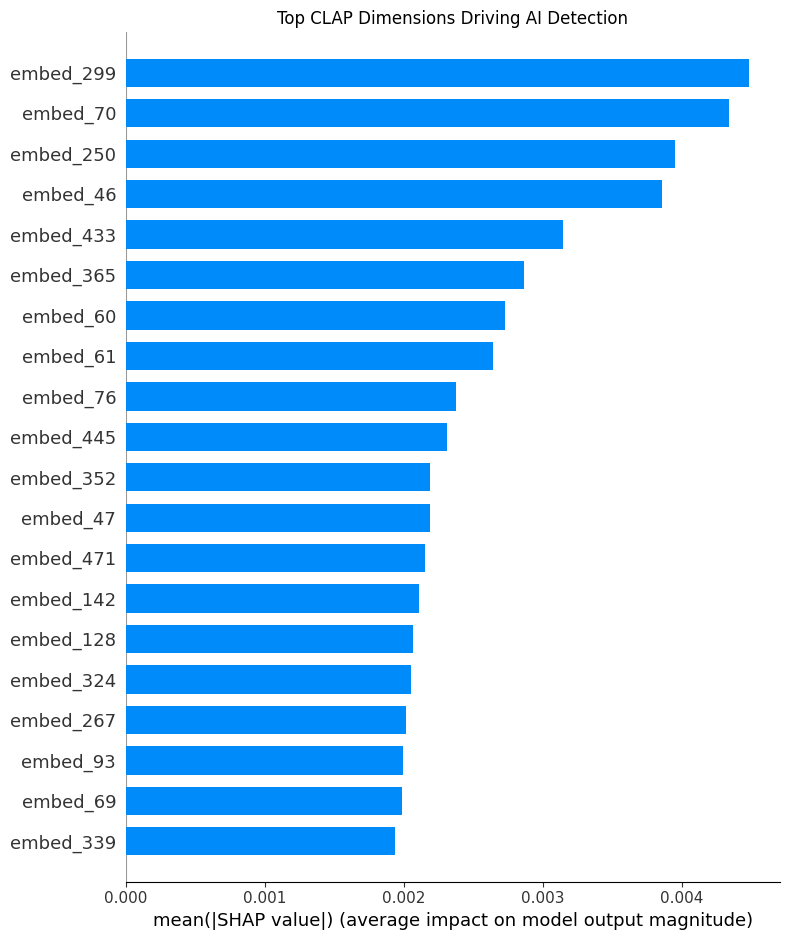

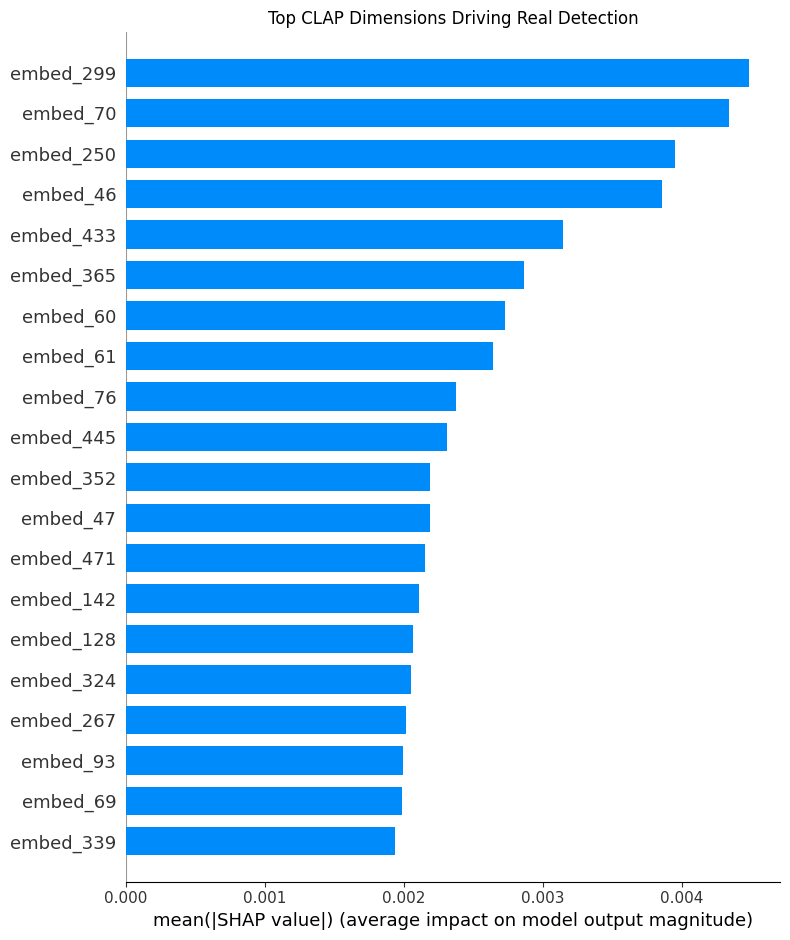

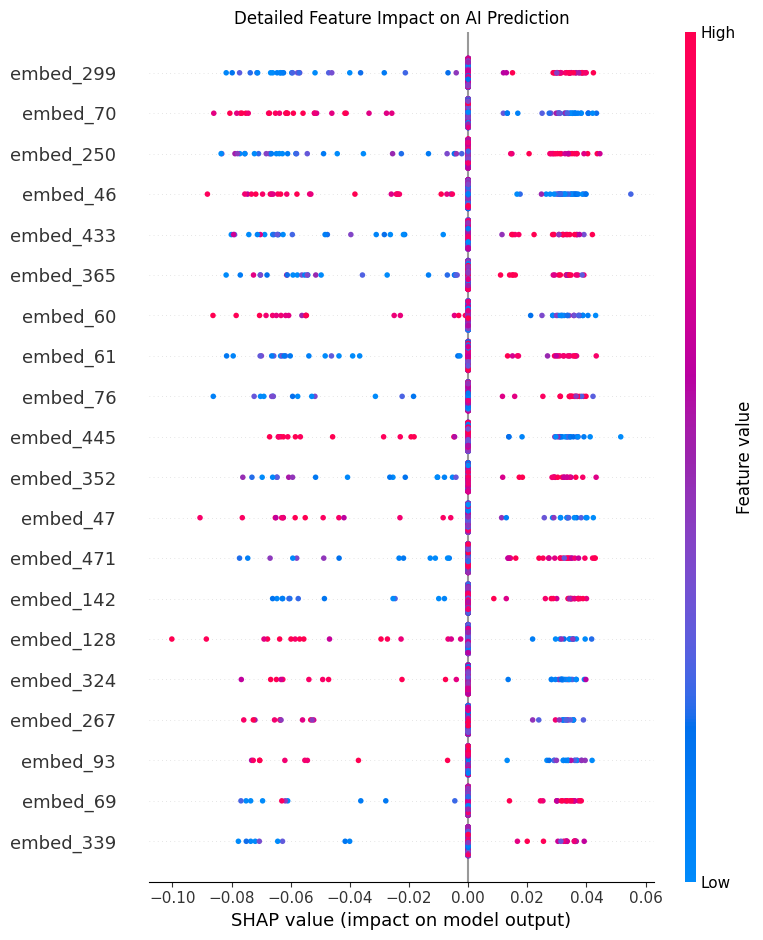

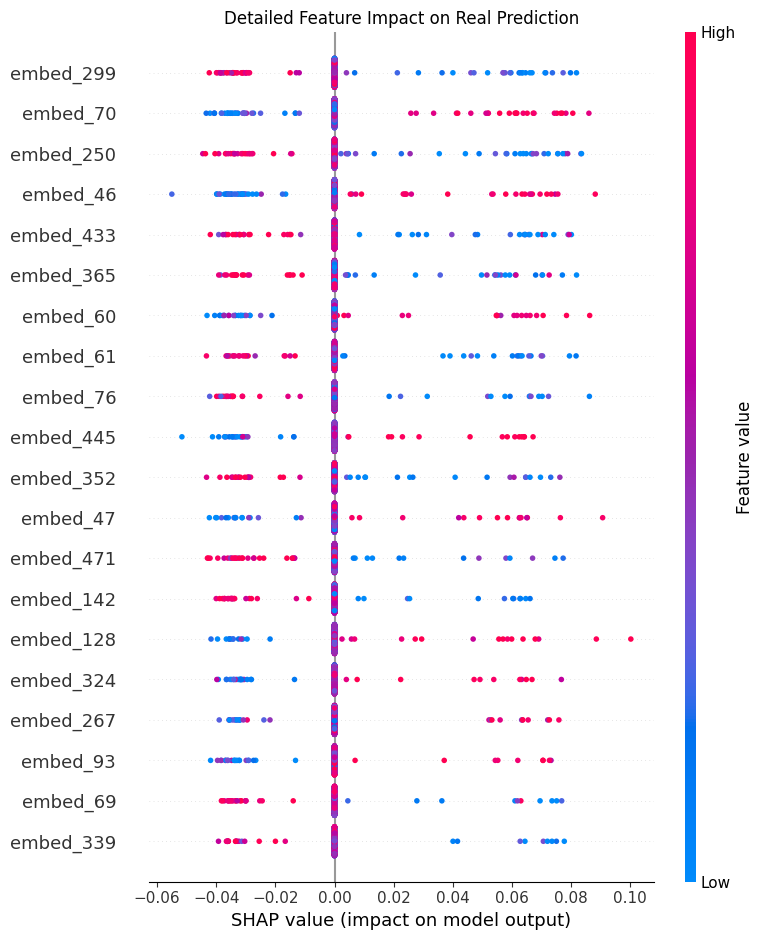

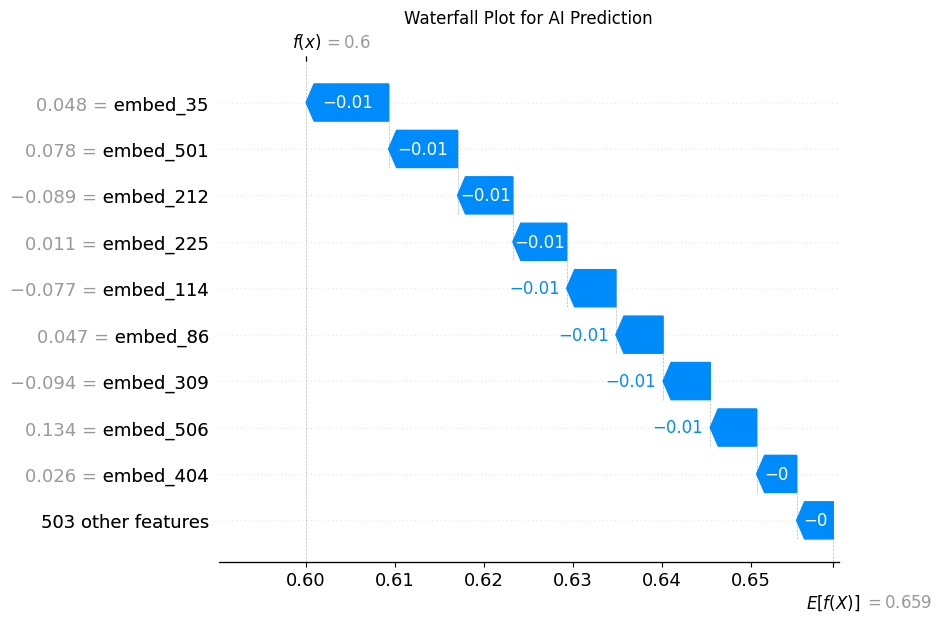

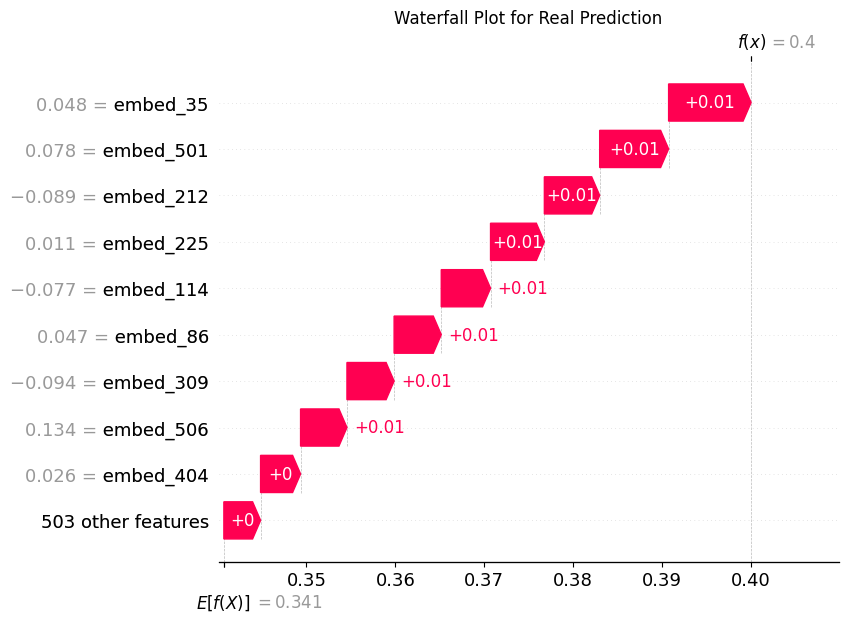

In [42]:
# Initialize KernelExplainer
background = shap.kmeans(X_train, 50)
explainer = shap.KernelExplainer(knn_model.predict_proba, background)

print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_test, check_additivity=False)
shap_values_real = shap_values[:, :, 0]
shap_values_ai = shap_values[:, :, 1]

# Plot 1: Global Feature Importance
# Use show=False and grab the figure before saving to avoid blank images
plt.title("Top CLAP Dimensions Driving AI Detection")
shap.summary_plot(shap_values_ai, X_test, plot_type="bar")
shap.summary_plot(shap_values_ai, X_test, plot_type="bar", show=False)
fig = plt.gcf()
fig.suptitle("Top CLAP Dimensions Driving AI Detection")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(target_path, "shap_summary_ai.png"))
plt.close(fig)

plt.title("Top CLAP Dimensions Driving Real Detection")
shap.summary_plot(shap_values_real, X_test, plot_type="bar")
shap.summary_plot(shap_values_real, X_test, plot_type="bar", show=False)
fig = plt.gcf()
fig.suptitle("Top CLAP Dimensions Driving Real Detection")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(target_path, "shap_summary_real.png"))
plt.close()

# Plot 2: Detailed Beeswarm Plot
plt.title("Detailed Feature Impact on AI Prediction")
shap.summary_plot(shap_values_ai, X_test)
shap.summary_plot(shap_values_ai, X_test, show=False)
fig = plt.gcf()
fig.suptitle("Detailed Feature Impact on AI Prediction")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(target_path, "shap_beeswarm_ai.png"))
plt.close()

plt.title("Detailed Feature Impact on Real Prediction")
shap.summary_plot(shap_values_real, X_test)
shap.summary_plot(shap_values_real, X_test, show=False)
fig = plt.gcf()
fig.suptitle("Detailed Feature Impact on Real Prediction")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(target_path, "shap_beeswarm_real.png"))
plt.close()

# Plot 3: Dependence Plot for Top Feature
explanation_ai = shap.Explanation(
    values=shap_values_ai,
    base_values=np.full(X_test.shape[0], explainer.expected_value[1]),
    data=X_test.values,
    feature_names=feature_names,
)

explanation_real = shap.Explanation(
    values=shap_values_real,
    base_values=np.full(X_test.shape[0], explainer.expected_value[0]),
    data=X_test.values,
    feature_names=feature_names,
)

plt.title("Waterfall Plot for AI Prediction")
shap.plots.waterfall(explanation_ai[1])
shap.plots.waterfall(explanation_ai[1], show=False)
fig = plt.gcf()
fig.suptitle("Waterfall Plot for AI Prediction")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(target_path, "shap_waterfall_ai.png"))
plt.close()

plt.title("Waterfall Plot for Real Prediction")
shap.plots.waterfall(explanation_real[1])
shap.plots.waterfall(explanation_real[1], show=False)
fig = plt.gcf()
fig.suptitle("Waterfall Plot for Real Prediction")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(target_path, "shap_waterfall_real.png"))
plt.close()